In [39]:
from control import NonlinearIOSystem, input_output_response, InterconnectedSystem
from numpy import linspace, matrix, arctan2, degrees

from matplotlib.pyplot import figure, rcParams
from conf_matplotlib import conf_matplotlib_oscuro
conf_matplotlib_oscuro()

In [62]:
def logic_ctl(t, x, u, params):
    
    n, te = u
    
    δt = 0.1
    
    N = int(t/δt)
    
    if n > N:
        s, d = 1, 1
    elif n < N:
        s, d = 1, 0
    else:
        s, d = 0, 0
    
    return [s, d]

def driver_state(t, x, u, params):
    nom_sec = params.get("secuencia_pasos", "HSD")
    
    if   nom_sec ==  "WD":
        # Wave drive
        lon_sec = 4
        
    elif nom_sec == "FSD":
        # Full step drive
        lon_sec = 4
        
    elif nom_sec == "HSD":
        # Half step drive
        lon_sec = 8
    
    s, d = u
    n = x
    
    N = n + s*(-1)**(d+1)
        
    return int(N % lon_sec)
    
def driver_ctl(t, x, u, params):
    nom_sec = params.get("secuencia_pasos", "HSD")
    
    if   nom_sec ==  "WD":
        # Wave drive
        secuencia = [[1,0,0,0], [0,0,1,0], [0,1,0,0], [0,0,0,1]]
        
    elif nom_sec == "FSD":
        # Full step drive
        secuencia = [[1,0,1,0], [0,1,1,0], [0,1,0,1], [1,0,0,1]]
        
    elif nom_sec == "HSD":
        # Half step drive
        secuencia = [[1,0,0,0],[1,0,1,0],[1,1,1,0],[0,1,1,0],
                     [0,1,1,1],[0,1,0,1],[0,0,0,1],[1,0,0,1]]
        
    #δ = 0.1
    #n = t/δ
    n = u
    
    m1, m2, m3, m4 = secuencia[int(n)%8]
    
    return [m1, m2, m3, m4]

In [63]:
io_log_ctl = NonlinearIOSystem(None, logic_ctl,
                               inputs=("n", "te"),
                               outputs=("s", "d"),
                               name="logic_ctl")

io_drv_state = NonlinearIOSystem(driver_state, None,
                                 inputs=("s", "d"),
                                 outputs=("n"),
                                 states=("n"),
                                 name="driver_state")

io_drv_ctl = NonlinearIOSystem(None, driver_ctl,
                               inputs=("n"),
                               outputs=("m1", "m2", "m3", "m4"),
                               name="driver_ctl")

In [64]:
driver = InterconnectedSystem(syslist=(io_log_ctl, io_drv_state, io_drv_ctl),
                             connections=(("driver_ctl.n", "driver_state.n"),
                                          ("driver_state.s", "logic_ctl.s"),
                                          ("driver_state.d", "logic_ctl.d"), 
                                          ("logic_ctl.n", "driver_state.n")),
                             inplist=("logic_ctl.te"),
                             outlist=("driver_ctl.m1", "driver_ctl.m2", "driver_ctl.m3", "driver_ctl.m4", "driver_state.n"))

In [65]:
ts = linspace(0, 1, 1000)

In [66]:
t, y = input_output_response(sys=driver, T=ts, U=ts, X0=[0], params={"secuencia_pasos":"HSD"})

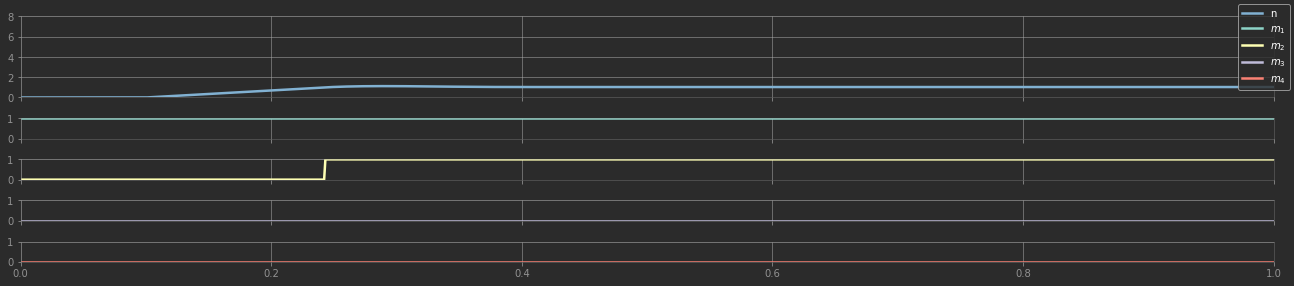

In [72]:
fig = figure(figsize=(18,4))
ax1, ax2, ax3, ax4, ax5 = fig.subplots(5, 1, sharex='all', gridspec_kw={'height_ratios': [4, 1, 1, 1, 1]})
cycle = rcParams['axes.prop_cycle'].by_key()['color']

ax1.plot(t, y[4], c=cycle[4], label=r"n")

ax2.plot(t, y[0], c=cycle[0], label=r"$m_1$")
ax3.plot(t, y[2], c=cycle[1], label=r"$m_2$")
ax4.plot(t, y[1], c=cycle[2], label=r"$m_3$")
ax5.plot(t, y[3], c=cycle[3], label=r"$m_4$")


ax1.set_ylim(0, 8)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)
ax4.set_ylim(0, 1)
ax5.set_ylim(0, 1)
ax5.set_xlim(min(t), max(t))
fig.legend()
fig.tight_layout();

In [17]:
def driver_pot(t, x, u, params):
    V = params.get("Vin", 5)
    
    m1, m2, m3, m4 = u
    
    v1 = (m1 - m2)*V
    v2 = (m3 - m4)*V
    
    return [v1, v2]

def coil_elec(t, x, u, params):
    L = params.get("L", 0.0015)
    R = params.get("R", 0.55)
    
    v1, v2, e1, e2 = u
    i1, i2 = x
    
    di1 = (v1 - e1 - R*i1)/L
    di2 = (v2 - e2 - R*i2)/L
    
    return [di1, di2]

def coil_torque(t, x, u, params):
    from numpy import arctan2, sqrt, sin, cos, pi
    Km = params.get("Km", 0.19)
    n_polos = params.get("n_polos", 50)
    R = params.get("R", 0.55)
    
    i1, i2, e1, e2, θ = u
    
    τ1 = -Km*(i1 - e1/R)*sin(θ*n_polos)
    τ2 =  Km*(i2 - e2/R)*cos(θ*n_polos)
    
    τ = τ1 + τ2
    
    return τ

def motor_mech(t, x, u, params):
    J = params.get("J", 0.000045)
    B = params.get("B", 0.0008)
    
    τ = u
    θ, ω = x
    
    dθ = ω
    ddθ = (τ - B*ω)/J
    
    return [dθ, ddθ]

def back_emf(t, x, u, params):
    from numpy import arctan2, degrees, sqrt, sin, cos, radians, pi
    Km = params.get("Km", 0.19)
    n_polos = params.get("n_polos", 50)
    
    θ, ω, i1, i2 = u
    
    e1 = -Km*ω*sin(θ*n_polos)
    e2 =  Km*ω*cos(θ*n_polos)
    
    return [e1, e2]

In [18]:
io_drv_pot = NonlinearIOSystem(None, driver_pot,
                               inputs=("m1", "m2", "m3", "m4"),
                               outputs=("v1", "v2"),
                               name="driver_pot")

io_coil_elec = NonlinearIOSystem(coil_elec, None,
                                 inputs=("v1", "v2", "e1", "e2"),
                                 outputs=("i1", "i2"),
                                 states=("i1", "i2"),
                                 name="coil_elec")

io_coil_torque = NonlinearIOSystem(None, coil_torque,
                                   inputs=("i1", "i2", "e1", "e2", "θ"),
                                   outputs=("τ"),
                                   name="coil_torque")

io_motor_mech = NonlinearIOSystem(motor_mech, None,
                                  inputs=("τ"),
                                  outputs=("θ", "ω"),
                                  states=("θ", "ω"),
                                  name="motor_mech")

io_back_emf = NonlinearIOSystem(None, back_emf,
                                inputs=("θ", "ω", "i1", "i2"),
                                outputs=("e1", "e2"),
                                name="back_emf")

In [19]:
motor = InterconnectedSystem(syslist=(io_drv_pot, io_coil_elec, io_coil_torque, io_motor_mech, io_back_emf),
                             connections=(("coil_elec.v1", "driver_pot.v1"),  ("coil_elec.v2", "driver_pot.v2"),
                                          ("coil_torque.i1", "coil_elec.i1"), ("coil_torque.i2", "coil_elec.i2"),
                                          ("coil_torque.θ", "motor_mech.θ"),  ("motor_mech.τ", "coil_torque.τ"),
                                          ("back_emf.θ", "motor_mech.θ"),     ("back_emf.ω", "motor_mech.ω"),
                                          ("back_emf.i1", "coil_elec.i1"),    ("back_emf.i2", "coil_elec.i2"),
                                          ("coil_elec.e1", "back_emf.e1"),    ("coil_elec.e2", "back_emf.e2"),
                                          ("coil_torque.e1", "back_emf.e1"),  ("coil_torque.e2", "back_emf.e2")),
                             inplist=("driver_pot.m1", "driver_pot.m2", "driver_pot.m3", "driver_pot.m4"),
                             outlist=("coil_elec.i1", "coil_elec.i2", "motor_mech.θ", "motor_mech.ω", "coil_torque.τ"))

In [20]:
ts = linspace(0, 1, 1000)

In [21]:
t, y = input_output_response(sys=motor, T=ts, U=ts, X0=[0,0,0,0,0], params={"secuencia_pasos":"HSD"})

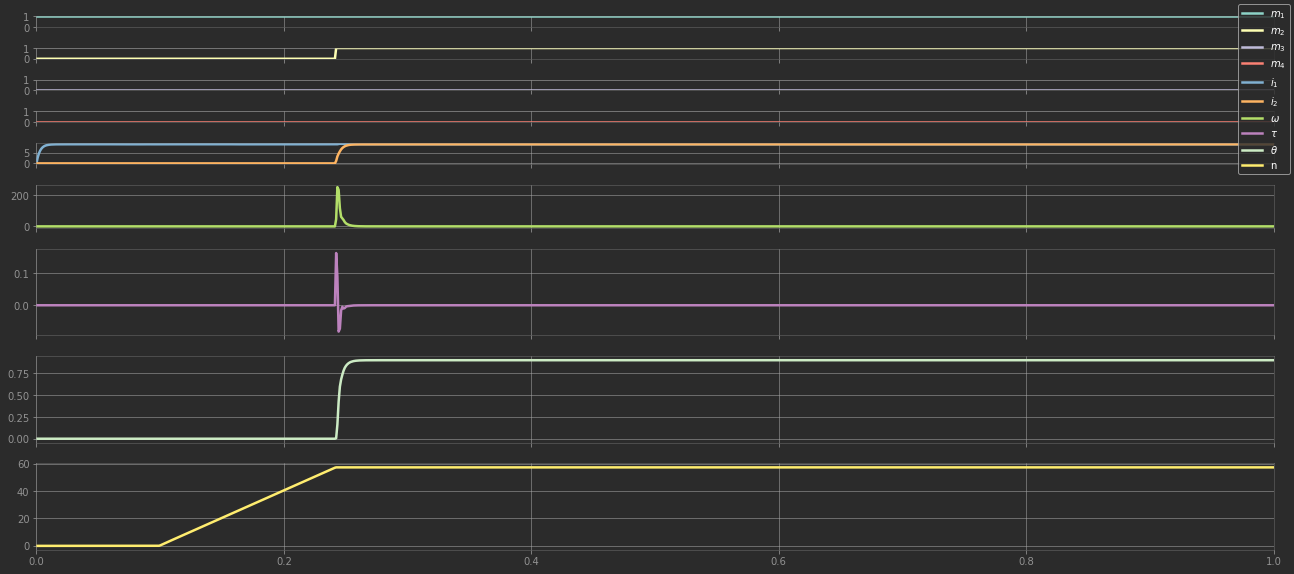

In [23]:
fig = figure(figsize=(18,8))
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = fig.subplots(9, 1, sharex='all',
                                                      gridspec_kw={'height_ratios': [1, 1, 1, 1, 2, 4, 8, 8, 8]})
cycle = rcParams['axes.prop_cycle'].by_key()['color']

ax1.plot(t, y[2], c=cycle[0], label=r"$m_1$")
ax2.plot(t, y[4], c=cycle[1], label=r"$m_2$")
ax3.plot(t, y[3], c=cycle[2], label=r"$m_3$")
ax4.plot(t, y[5], c=cycle[3], label=r"$m_4$")

ax5.plot(t, y[0], c=cycle[4], label=r"$i_1$")
ax5.plot(t, y[1], c=cycle[5], label=r"$i_2$")

ax6.plot(t, degrees(y[7]), c=cycle[6], label=r"$\omega$")

ax7.plot(t, y[8], c=cycle[7], label=r"$\tau$")

ax8.plot(t, degrees(y[6]), c=cycle[8], label=r"$\theta$")
ax9.plot(t, degrees(y[9]), c=cycle[9], label=r"n")

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)
ax4.set_ylim(0, 1)
ax7.set_xlim(min(t), max(t))
fig.legend()
fig.tight_layout();